# About this notebook
- This notebook is to analyze and visualize the Covid-19 cases evolution spatially and temporally
- The Covid-19 data are downloaded from JHU-CSSEGIS (https://github.com/CSSEGISandData/COVID-19)
- The geo-json data are from Plotly (https://github.com/plotly/datasets)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, findspark

spark_home = os.getenv('SPARK_HOME')
findspark.init(spark_home)

In [3]:
from pyspark import SparkConf
sc = SparkConf()

from pyspark.sql import SparkSession
spark = SparkSession.builder.config(conf=sc).getOrCreate()
spark

In [4]:
import sys
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.sql import DataFrame

## Get data

In [6]:
# county-level geo json data

from urllib.request import urlopen

data_url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"

res = urlopen(data_url)
counties = json.load(res)

In [7]:
# US county data

df_counties = spark.read.csv('data/Counties.csv', header=True) \
    .select(F.col('X1').alias('state'), F.concat(F.col('X2'), F.col('X3')).alias('FIPS'), F.col('X4').alias('county'))

In [8]:
df_counties.show(2)

+-----+-----+--------------+
|state| FIPS|        county|
+-----+-----+--------------+
|   AL|01001|Autauga County|
|   AL|01003|Baldwin County|
+-----+-----+--------------+
only showing top 2 rows



In [9]:
# Covid-19 related data, snapshot_date = 2020-08-01

df_confirmed = spark.read.csv('data/time_series_covid19_confirmed_US.csv', header=True, inferSchema=True) \
    .fillna(0) \
    .withColumn('FIPS', F.format_string('%05d', F.col('FIPS').cast(T.IntegerType())))

df_death = spark.read.csv('data/time_series_covid19_deaths_US.csv', header=True, inferSchema=True) \
    .fillna(0) \
    .filter('Population > 0') \
    .withColumn('FIPS', F.format_string('%05d', F.col('FIPS').cast(T.IntegerType())))

## Section 1: Process and visualize the Covid-19 cases until 2020-07-31

### Section 1a: Process the data

In [10]:
# join df_confirmed and df_death dataframes to make a master table

df_us = df_confirmed.select('FIPS', 'Combined_Key', F.col(df_confirmed.columns[-1]).alias('confirmed_cases')) \
.join(df_death.select('FIPS', 'Combined_Key', 'Population', F.col(df_death.columns[-1]).alias('death_cases')),
      on=['FIPS', 'Combined_Key'])

In [11]:
df_us.printSchema()

root
 |-- FIPS: string (nullable = false)
 |-- Combined_Key: string (nullable = true)
 |-- confirmed_cases: integer (nullable = true)
 |-- Population: integer (nullable = true)
 |-- death_cases: integer (nullable = true)



In [12]:
df_us.show(5)

+-----+--------------------+---------------+----------+-----------+
| FIPS|        Combined_Key|confirmed_cases|Population|death_cases|
+-----+--------------------+---------------+----------+-----------+
|00060|  American Samoa, US|              0|     55641|          0|
|00066|            Guam, US|            356|    164229|          5|
|00069|Northern Mariana ...|             42|     55144|          2|
|72001|Adjuntas, Puerto ...|             82|     19483|          0|
|72003|Aguada, Puerto Ri...|             99|     41959|          0|
+-----+--------------------+---------------+----------+-----------+
only showing top 5 rows



In [13]:
# compute infection rates
df_us = df_us \
    .withColumn('Infection_Rate', F.round(F.col('confirmed_cases')/F.col('Population'), 5)) \
    .withColumn('Fatality_Rate', F.round(F.col('death_cases')/F.col('confirmed_cases'), 5)) \
    .withColumnRenamed('Combined_Key', 'County')

In [14]:
# join with df_counties to get the state column

df_us = df_us \
    .join(df_counties.select('FIPS', 'state'), on='FIPS')

In [15]:
df_us.show(5, False)

+-----+-----------------------------+---------------+----------+-----------+--------------+-------------+-----+
|FIPS |County                       |confirmed_cases|Population|death_cases|Infection_Rate|Fatality_Rate|state|
+-----+-----------------------------+---------------+----------+-----------+--------------+-------------+-----+
|72001|Adjuntas, Puerto Rico, US    |82             |19483     |0          |0.00421       |0.0          |PR   |
|72003|Aguada, Puerto Rico, US      |99             |41959     |0          |0.00236       |0.0          |PR   |
|72005|Aguadilla, Puerto Rico, US   |168            |60949     |0          |0.00276       |0.0          |PR   |
|72007|Aguas Buenas, Puerto Rico, US|102            |28659     |0          |0.00356       |0.0          |PR   |
|72009|Aibonito, Puerto Rico, US    |73             |25900     |0          |0.00282       |0.0          |PR   |
+-----+-----------------------------+---------------+----------+-----------+--------------+-------------

In [16]:
# sanity check

df_us.select(F.min('population'), F.max('Infection_Rate'), F.max('Fatality_Rate')).show()

+---------------+-------------------+------------------+
|min(population)|max(Infection_Rate)|max(Fatality_Rate)|
+---------------+-------------------+------------------+
|             86|            0.13914|              0.25|
+---------------+-------------------+------------------+



In [17]:
# take a look at the counties with the largest number of confirmed cases

df_us.orderBy(F.desc('confirmed_cases')).show(20, False)

+-----+------------------------------+---------------+----------+-----------+--------------+-------------+-----+
|FIPS |County                        |confirmed_cases|Population|death_cases|Infection_Rate|Fatality_Rate|state|
+-----+------------------------------+---------------+----------+-----------+--------------+-------------+-----+
|36061|New York City, New York, US   |225148         |8336817   |23531      |0.02701       |0.10451      |NY   |
|06037|Los Angeles, California, US   |188541         |10039107  |4624       |0.01878       |0.02453      |CA   |
|12086|Miami-Dade, Florida, US       |118462         |2716940   |1611       |0.0436        |0.0136       |FL   |
|04013|Maricopa, Arizona, US         |117293         |4485414   |2054       |0.02615       |0.01751      |AZ   |
|17031|Cook, Illinois, US            |105493         |5150233   |4886       |0.02048       |0.04632      |IL   |
|48201|Harris, Texas, US             |72961          |4713325   |730        |0.01548       |0.01

In [18]:
# I live in CA, so let us look at the top counties in CA

df_us.filter(F.col('state') == 'CA').orderBy(F.desc('confirmed_cases')).show(10, False)

+-----+------------------------------+---------------+----------+-----------+--------------+-------------+-----+
|FIPS |County                        |confirmed_cases|Population|death_cases|Infection_Rate|Fatality_Rate|state|
+-----+------------------------------+---------------+----------+-----------+--------------+-------------+-----+
|06037|Los Angeles, California, US   |188541         |10039107  |4624       |0.01878       |0.02453      |CA   |
|06065|Riverside, California, US     |37011          |2470546   |695        |0.01498       |0.01878      |CA   |
|06059|Orange, California, US        |36196          |3175692   |618        |0.0114        |0.01707      |CA   |
|06071|San Bernardino, California, US|32230          |2180085   |409        |0.01478       |0.01269      |CA   |
|06073|San Diego, California, US     |29048          |3338330   |561        |0.0087        |0.01931      |CA   |
|06029|Kern, California, US          |19335          |900202    |140        |0.02148       |0.00

### Section 1b: Spatial visualization of Covid-19 cumulative cases and deaths until 2020-07-31

In [19]:
# convert to Pandas for visualization

pandas_us = df_us.toPandas()

/opt/anaconda3/envs/spark/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


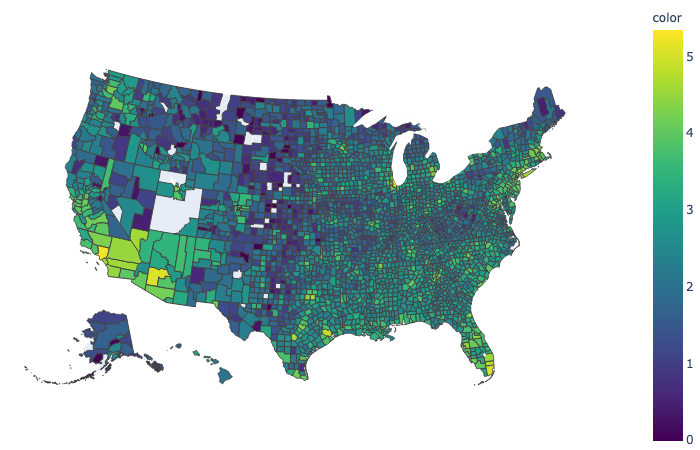

In [20]:
# the number of confirmed cases in log-scale

fig = px.choropleth(
    pandas_us,
    geojson=counties,
    locations='FIPS',
    color=np.log10(pandas_us['confirmed_cases']),
    color_continuous_scale='viridis',
    range_color=(0, np.max(np.log10(pandas_us['confirmed_cases']))),
    scope='usa'
)

fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})

# Output static image; Uncomment the following line to get interactive plotly graph
fig.show('png')

/opt/anaconda3/envs/spark/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log10



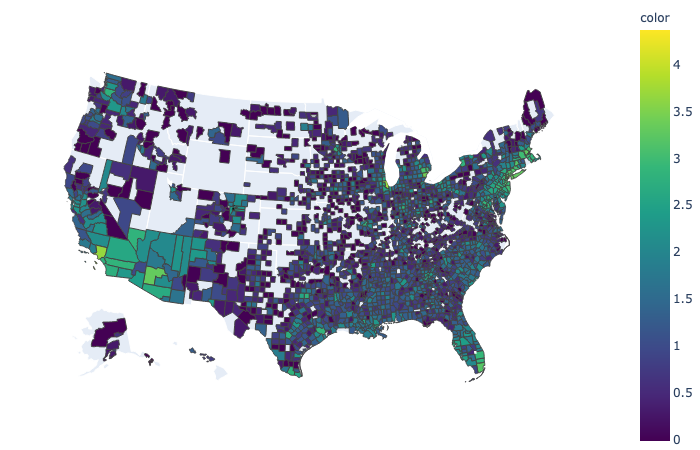

In [21]:
# the number of death cases in log-scale

fig = px.choropleth(
    pandas_us,
    geojson=counties,
    locations='FIPS',
    color=np.log10(pandas_us['death_cases']),
    color_continuous_scale='viridis',
    range_color=(0, np.max(np.log10(pandas_us['death_cases']))),
    scope='usa'
)

fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show('png')

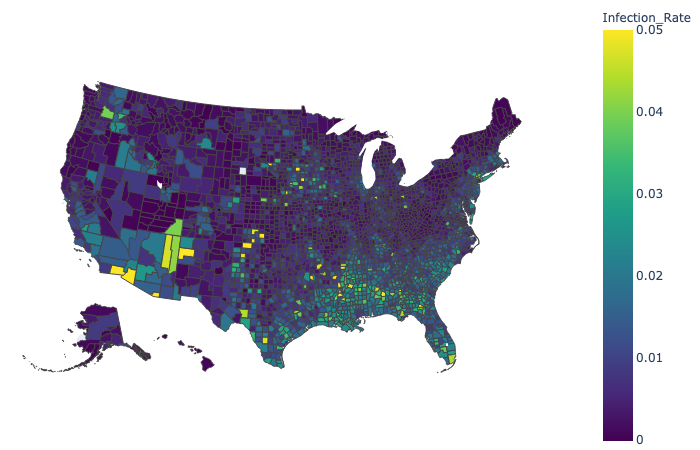

In [22]:
# the infection rate

fig = px.choropleth(
    pandas_us,
    geojson=counties,
    locations='FIPS',
    color=pandas_us['Infection_Rate'],
    color_continuous_scale='viridis',
    range_color=(0, 0.05), # the range comes from trial-and-error
    scope='usa'
)

fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show('png')

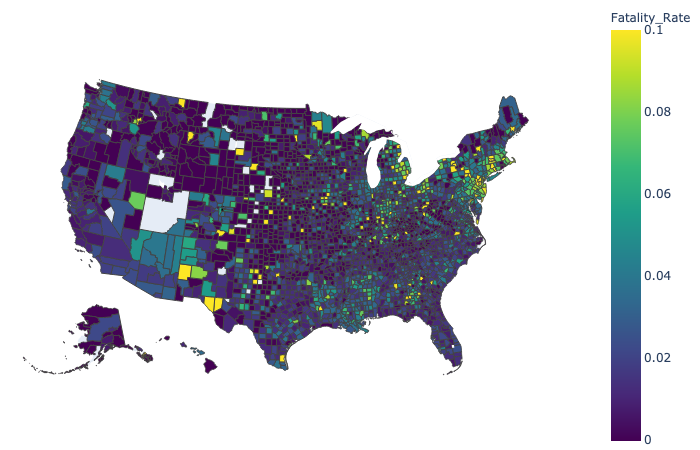

In [23]:
# the death rate

fig = px.choropleth(
    pandas_us,
    geojson=counties,
    locations='FIPS',
    color=pandas_us['Fatality_Rate'],
    color_continuous_scale='viridis',
    range_color=(0, 0.1), # the range comes from trial-and-error
    scope='usa'
)

fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show('png')

## Section 2: Process and compute the pandemic growth kinetics

### Section 2a: Process the data

In [24]:
pd_confirmed = df_confirmed \
    .withColumnRenamed('Combined_Key', 'county') \
    .join(df_counties.select('FIPS', 'state'), on='FIPS') \
    .toPandas()

In [25]:
pd_confirmed.head()

,FIPS,UID,iso2,iso3,code3,Admin2,Province_State,Country_Region,Lat,Long_,...,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,state
0,72001,63072001,PR,PRI,630,Adjuntas,Puerto Rico,US,18.180117,-66.754367,...,72,73,74,77,77,77,77,78,82,PR
1,72003,63072003,PR,PRI,630,Aguada,Puerto Rico,US,18.360255,-67.175131,...,82,84,89,91,92,95,96,97,99,PR
2,72005,63072005,PR,PRI,630,Aguadilla,Puerto Rico,US,18.459681,-67.120815,...,130,135,142,152,156,160,160,166,168,PR
3,72007,63072007,PR,PRI,630,Aguas Buenas,Puerto Rico,US,18.251619,-66.126806,...,85,87,91,94,94,97,99,102,102,PR
4,72009,63072009,PR,PRI,630,Aibonito,Puerto Rico,US,18.131361,-66.264131,...,64,64,67,70,70,71,71,73,73,PR


In [26]:
# unpivot the columns

cols_to_keep = list(pd_confirmed.columns[11:]) + ['FIPS', 'county']
pd_cases = pd.melt(pd_confirmed[cols_to_keep], id_vars=['FIPS', 'county', 'state'], var_name='date', value_name='confirmed_cases', ignore_index=False)

In [27]:
pd_cases.head()

,FIPS,county,state,date,confirmed_cases
0,72001,"Adjuntas, Puerto Rico, US",PR,1/22/20,0
1,72003,"Aguada, Puerto Rico, US",PR,1/22/20,0
2,72005,"Aguadilla, Puerto Rico, US",PR,1/22/20,0
3,72007,"Aguas Buenas, Puerto Rico, US",PR,1/22/20,0
4,72009,"Aibonito, Puerto Rico, US",PR,1/22/20,0


In [28]:
# convert object to string but keep date and int format

pd_cases = pd_cases.astype(str)
pd_cases['confirmed_cases'] = pd_cases['confirmed_cases'].astype(int)
pd_cases['date'] = pd.to_datetime(pd_cases['date']).dt.date

In [29]:
# convert back to spark dataframe

df_cases = spark.createDataFrame(pd_cases)

In [30]:
# check schema and data type

df_cases.printSchema()

root
 |-- FIPS: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- date: date (nullable = true)
 |-- confirmed_cases: long (nullable = true)



In [31]:
df_cases.show(5, False)

+-----+-----------------------------+-----+----------+---------------+
|FIPS |county                       |state|date      |confirmed_cases|
+-----+-----------------------------+-----+----------+---------------+
|72001|Adjuntas, Puerto Rico, US    |PR   |2020-01-22|0              |
|72003|Aguada, Puerto Rico, US      |PR   |2020-01-22|0              |
|72005|Aguadilla, Puerto Rico, US   |PR   |2020-01-22|0              |
|72007|Aguas Buenas, Puerto Rico, US|PR   |2020-01-22|0              |
|72009|Aibonito, Puerto Rico, US    |PR   |2020-01-22|0              |
+-----+-----------------------------+-----+----------+---------------+
only showing top 5 rows



In [32]:
# compute the top 5 counties with most cases in CA

df_cases \
.filter(F.col('state') == 'CA') \
.withColumn('last_date', F.max('date').over(Window.partitionBy())) \
.filter(F.col('date') == F.col('last_date')) \
.orderBy(F.desc('confirmed_cases')) \
.show(5, False)

+-----+------------------------------+-----+----------+---------------+----------+
|FIPS |county                        |state|date      |confirmed_cases|last_date |
+-----+------------------------------+-----+----------+---------------+----------+
|06037|Los Angeles, California, US   |CA   |2020-07-31|188541         |2020-07-31|
|06065|Riverside, California, US     |CA   |2020-07-31|37011          |2020-07-31|
|06059|Orange, California, US        |CA   |2020-07-31|36196          |2020-07-31|
|06071|San Bernardino, California, US|CA   |2020-07-31|32230          |2020-07-31|
|06073|San Diego, California, US     |CA   |2020-07-31|29048          |2020-07-31|
+-----+------------------------------+-----+----------+---------------+----------+
only showing top 5 rows



### Process 2b: Visualize the number of confirmed cases over time for 5 counties in CA

In [33]:
# let us get the FIPS for the counties we would like to model

fips = df_cases \
.filter(F.col('state') == 'CA') \
.withColumn('last_date', F.max('date').over(Window.partitionBy())) \
.filter(F.col('date') == F.col('last_date')) \
.orderBy(F.desc('confirmed_cases')) \
.limit(5) \
.select('FIPS')

df_ca5 = df_cases \
    .join(fips, on='FIPS')

In [34]:
# conver to pandas

pd_ca5 = df_ca5.toPandas()

In [35]:
pd_ca5.head()

,FIPS,county,state,date,confirmed_cases
0,06037,"Los Angeles, California, US",CA,2020-01-22,0
1,06059,"Orange, California, US",CA,2020-01-22,0
2,06065,"Riverside, California, US",CA,2020-01-22,0
3,06071,"San Bernardino, California, US",CA,2020-01-22,0
4,06073,"San Diego, California, US",CA,2020-01-22,0


In [36]:
import seaborn as sns

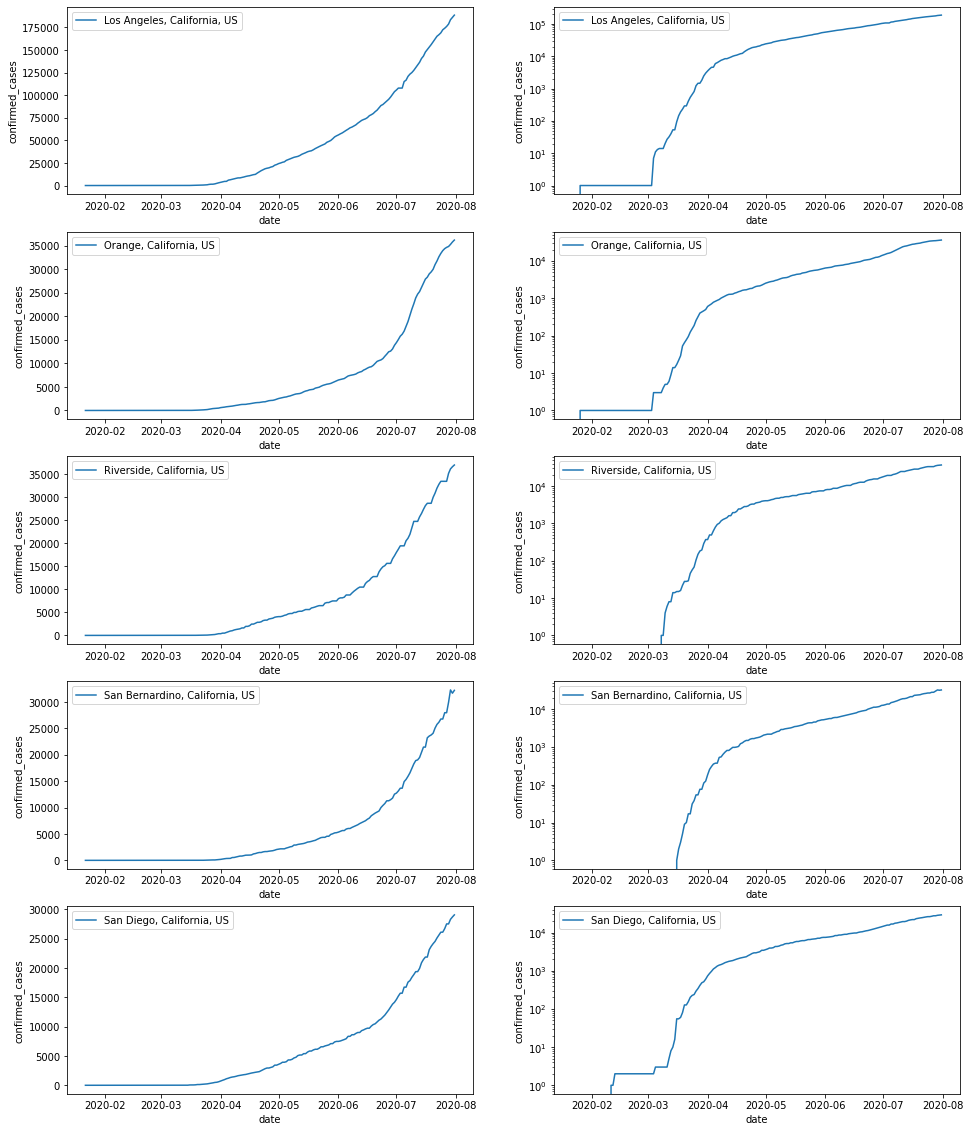

In [37]:
# visualize the number of cumulative confirmed cases over time

fig, axes = plt.subplots(5, 2, figsize=(16, 20))

for i, county in enumerate(pd_ca5['county'].unique()):
    # filter data for plotting
    pd_plot = pd_ca5[pd_ca5.county == county][['date', 'confirmed_cases']].sort_values('date')
    
    # linear plot
    sns.lineplot(x='date', y='confirmed_cases', data=pd_plot, ax=axes[i][0], label=county)
    
    # log scale y-axis plot
    sns.lineplot(x='date', y='confirmed_cases', data=pd_plot, ax=axes[i][1], label=county)
    axes[i][1].set(yscale="log")

### Process 2c: Modeling the case growth using a logistic growth model
- There are many studies that use logistic growth model to fit and understand COVID-19 spread, such as
    - https://www.sciencedirect.com/science/article/pii/S1201971220303039
    - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0235247


- In the logistic growth model, the growth rate goes down over time, and eventually to zero, which mimics the pandemic spread as well

In [38]:
# fit to a logistic growth model

def logistic_growth(x, a, n, tau):
    return a / (1 + n* np.exp(-x/tau))

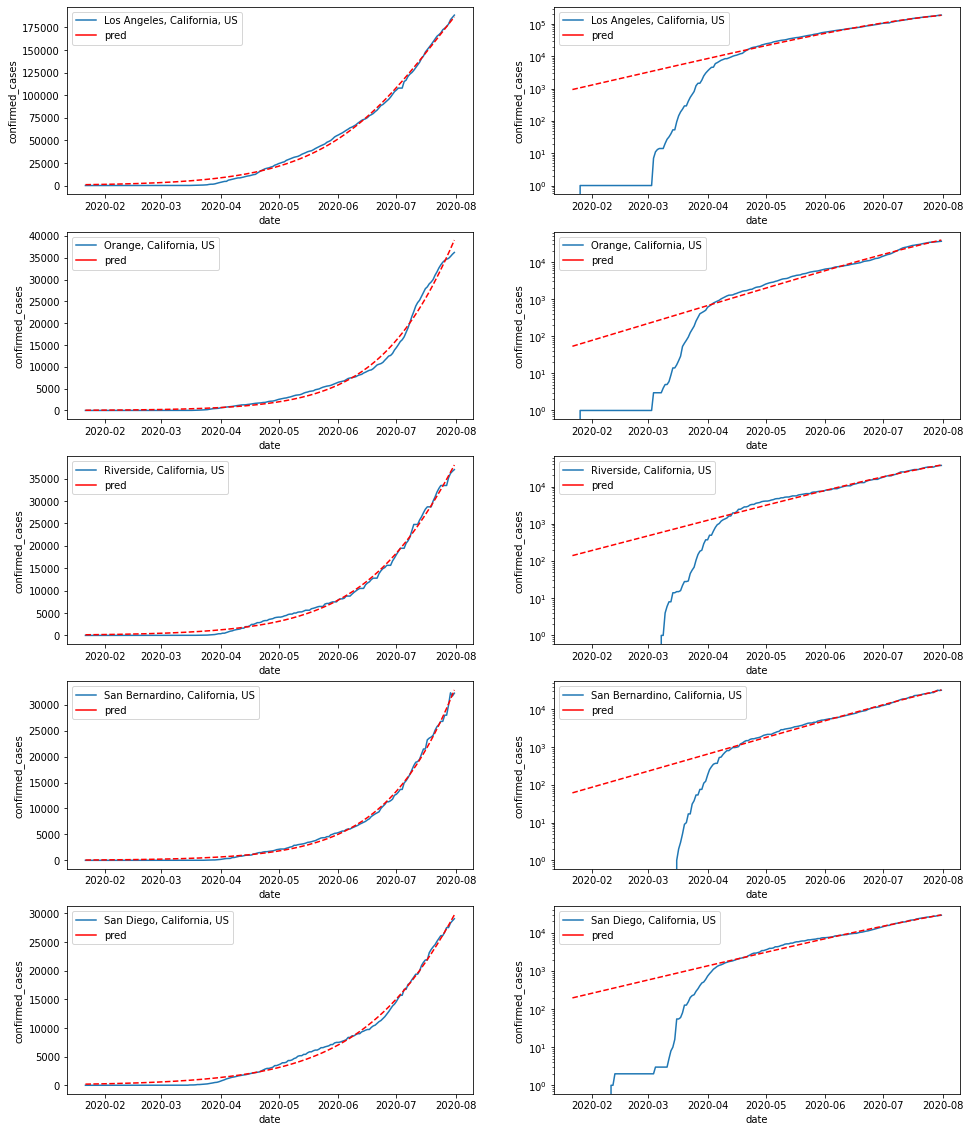

In [39]:
from scipy.optimize import curve_fit

# two dataframes to store the fitting results
pd_pred = pd.DataFrame(columns=['county', 'max_cases', 'growth_rate', 'confirmed_cases'])
pd_params = pd.DataFrame(columns=['a', 'n', 'tau'])

fig, axes = plt.subplots(5, 2, figsize=(16, 20))

for i, county in enumerate(pd_ca5['county'].unique()):
    # filter data for plotting
    pd_plot = pd_ca5[pd_ca5.county == county][['date', 'confirmed_cases']].sort_values('date').reset_index(drop=True)
    
    # linear plot
    sns.lineplot(x='date', y='confirmed_cases', data=pd_plot, ax=axes[i][0], label=county)
    
    # log scale y-axis plot
    sns.lineplot(x='date', y='confirmed_cases', data=pd_plot, ax=axes[i][1], label=county)
    axes[i][1].set(yscale="log")
    
    # curve fit
    popt, _ = curve_fit(logistic_growth, pd_plot.index, pd_plot.confirmed_cases.values, p0=np.array([20000, 1000, 5]))
    
    # plot the fitted curve
    sns.lineplot(pd_plot.date, logistic_growth(pd_plot.index, *popt), label='pred', ax=axes[i][0], color='red')
    sns.lineplot(pd_plot.date, logistic_growth(pd_plot.index, *popt), label='pred', ax=axes[i][1], color='red')
    axes[i][0].lines[1].set_linestyle("--")
    axes[i][1].lines[1].set_linestyle("--")
    
    # extract the max cases and growth rate
    max_cases, growth_rate = popt[0], 1/popt[2]
    pd_pred = pd_pred.append({
        'county':county,
        'max_cases':max_cases,
        'growth_rate':growth_rate,
        'confirmed_cases':pd_plot.iloc[-1]['confirmed_cases']
    }, ignore_index=True)
    
    pd_params = pd_params.append({'county':county, 'a':popt[0], 'n':popt[1], 'tau': popt[2]}, ignore_index=True)

### Section 2d: Rationalize the growth model parameters

In [40]:
pd_pred.set_index('county', inplace=True)
pd_params.set_index('county', inplace=True)

In [41]:
pd_pred.head()

,max_cases,growth_rate,confirmed_cases
county,,,
"Los Angeles, California, US",339738.611307,0.031875,188541
"Orange, California, US",142778.607003,0.036166,36196
"Riverside, California, US",121076.172771,0.031322,37011
"San Bernardino, California, US",194916.822171,0.033851,32230
"San Diego, California, US",117629.998946,0.027787,29048


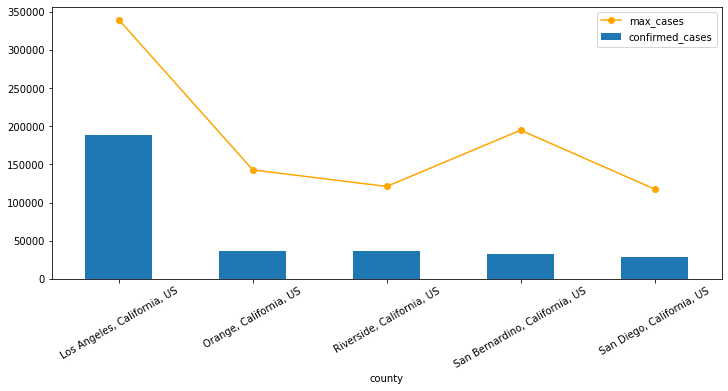

In [42]:
# visualize the prediction of max_cases

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

pd_pred['confirmed_cases'].plot.bar(ax=ax, label='confirmed_cases');
pd_pred['max_cases'].plot.line(rot=30, ax=ax, color='orange', label='max_cases', marker='o');
ax.legend();

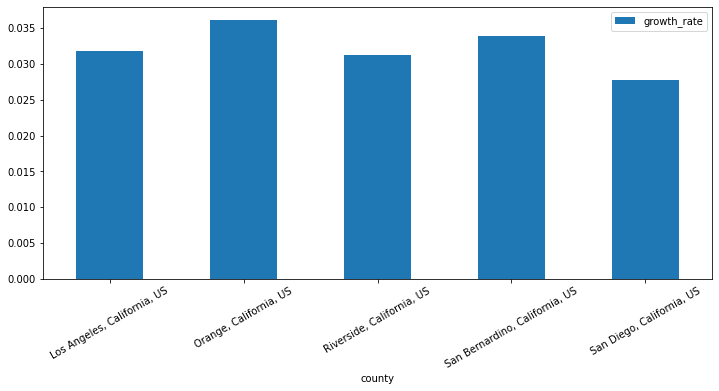

In [43]:
# visualize the prediction of growth rate

pd_pred[['growth_rate']].plot.bar(figsize=(12, 5), rot=30);

In [44]:
# predict into the future to see how long the pandemic is going to last for the Orange County

from datetime import timedelta

num_days = 365

min_date = pd_plot['date'].min()
date_list = [min_date + timedelta(days=x) for x in range(num_days)]
popt = pd_params.loc['Orange, California, US'].astype(float).values

pd_pred_ts = pd.DataFrame(date_list, columns=['date']).sort_values('date').reset_index(drop=True)
pd_pred_ts['pred_cases'] = logistic_growth(pd_pred_ts.index, *popt)

In [45]:
pd_pred_ts['pred_new_cases'] = pd_pred_ts['pred_cases'].diff()

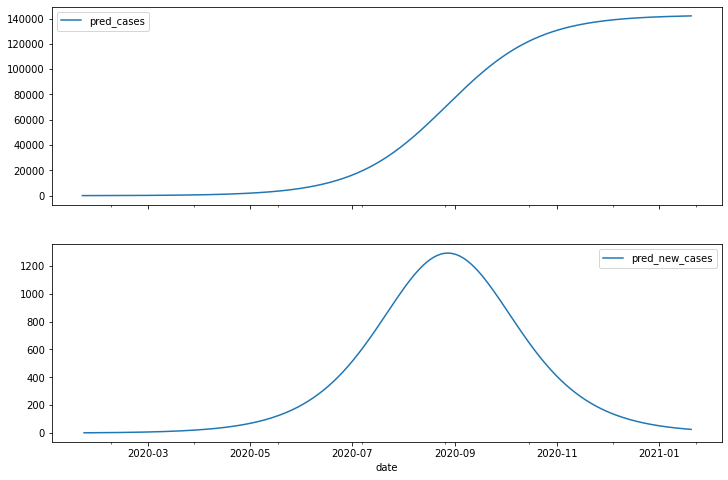

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
pd_pred_ts.plot.line(x='date', y='pred_cases', ax=axes[0]);
pd_pred_ts.plot.line(x='date', y='pred_new_cases', ax=axes[1]);

# Conclusions
- There are two slopes in the log-plot, which means the Covid-19 growth is decreases
- The predicted maximum cases are many times than the confirmed cases so far, which means the Covid-19 is not over yet!
- The predicted logistic growth curve shows that the pandemic will likely peak around September and start to diminish in the winter